In [14]:
# import libraries
from pandas_datareader import data as web
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [11]:
# list of FAANG stocks we'll be tracking, can be editeds
assets = ['BAC''AMZN,', 'AAPL', 'NFLX', 'GOOG']

In [40]:
# starting date (10 years ago)
start_date = '2013-01-01'

# ending date (today)
end_date = datetime.today().strftime('%Y-%m-%d')

In [41]:
# create an empty DataFrame with columns for each stock symbol
df = pd.DataFrame()

# retrieve and store the close prices into df
for stock in assets:
    data = yf.download(stock, start=start_date, end=end_date)
    df[stock] = data['Adj Close']

df


[*********************100%***********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,FB,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,NaN,12.865500,16.813864,13.144286,18.013729
2013-01-03,NaN,12.924000,16.601627,13.798571,18.024191
2013-01-04,NaN,12.957500,16.139196,13.711429,18.380356
2013-01-07,NaN,13.423000,16.044262,14.171429,18.300158
2013-01-08,NaN,13.319000,16.087444,13.880000,18.264042
...,...,...,...,...,...
2023-06-22,NaN,130.149994,187.000000,422.480011,123.870003
2023-06-23,NaN,129.330002,186.679993,424.019989,123.019997
2023-06-26,NaN,127.330002,185.270004,415.940002,119.089996


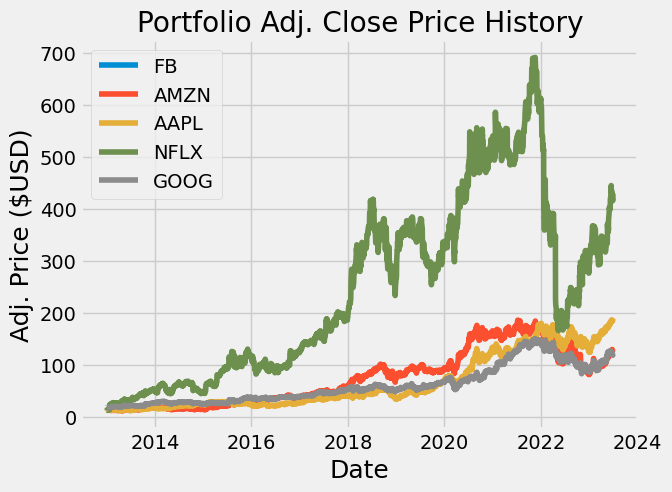

In [42]:
# visualize stock data
title = 'Portfolio Adj. Close Price History'

# get stocks
my_stocks = df

# create and plot data
for c in my_stocks.columns.values:
  plt.plot(my_stocks[c], label = c)

plt.title(title)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adj. Price ($USD)', fontsize = 18)
plt.legend(my_stocks.columns.values, loc = 'upper left')
plt.show()

In [43]:
# display daily simple return
returns = df.pct_change()
returns

,FB,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,0.004547,-0.012623,0.049777,0.000581
2013-01-04,NaN,0.002592,-0.027855,-0.006315,0.019760
2013-01-07,NaN,0.035925,-0.005882,0.033549,-0.004363
2013-01-08,NaN,-0.007748,0.002691,-0.020565,-0.001974
...,...,...,...,...,...
2023-06-22,NaN,0.042618,0.016525,-0.004641,0.021524
2023-06-23,NaN,-0.006300,-0.001711,0.003645,-0.006862
2023-06-26,NaN,-0.015464,-0.007553,-0.019056,-0.031946


In [44]:
# create and show the annualized covariance matrix
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,FB,AMZN,AAPL,NFLX,GOOG
FB,NaN,NaN,NaN,NaN,NaN
AMZN,NaN,0.107333,0.047644,0.073927,0.056714
AAPL,NaN,0.047644,0.082724,0.043528,0.044958
NFLX,NaN,0.073927,0.043528,0.224128,0.055866
GOOG,NaN,0.056714,0.044958,0.055866,0.075364


In [47]:
# assign weights to the stocks
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

In [54]:
from scipy.linalg import sqrtm

# handle missing values in covariance matrix
cov_matrix_annual[np.isnan(cov_matrix_annual)] = 0

# ensure positive definite covariance matrix
epsilon = 1e-6
cov_matrix_annual += epsilon * np.eye(cov_matrix_annual.shape[0])

# calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.04539302019815361

In [55]:
# calculate portfolio volatility / standard deviation
port_volatility = np.sqrt(port_variance)
port_volatility

0.21305637798046229

In [56]:
# calculate portfolio's simple annual return
port_simple_annual_return = np.sum(returns.mean() * weights) * 252
port_simple_annual_return

0.24208257091086885

In [57]:
# expected annual return, volatility (risk), and variance
percent_var = str(round(port_variance, 2) * 100) + '%'
percent_vols = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(port_simple_annual_return, 2) * 100) + '%'

print('Expected annual return: ' + percent_ret)
print('Annual volatility / risk: ' + percent_vols)
print('Annual variance: ' + percent_var)

Expected annual return: 24.0%
Annual volatility / risk: 21.0%
Annual variance: 5.0%


In [58]:
!pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.4 MB/s eta 0:00:00


In [60]:
# import portfolio optimization libraries
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [62]:
# calculate expected returns and covariance matrix
mu = expected_returns.mean_historical_return(df)
S = risk_models.CovarianceShrinkage(df).ledoit_wolf()

# optimize for max sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('FB', 0.0), ('AMZN', 0.11466), ('AAPL', 0.56261), ('NFLX', 0.3151), ('GOOG', 0.00763)])
Expected annual return: 30.1%
Annual volatility: 27.8%
Sharpe Ratio: 1.01


(0.30059958077282634, 0.277502043893816, 1.0111622128455227)

In [63]:
0.11466 + 0.56261 + 0.3151 + 0.00763

1.0